# Vaccine Sentiment Classification
*by Nefeli Tavoulari*

#### In this notebook I classify tweets as Neutral, Pro-vax or Anti-vax using the pretrained BERT-base model .

## Install Dependencies

In [ ]:
!pip install transformers

## Import Packages

In [ ]:
%matplotlib inline
import io
import re
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import re
import csv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AutoTokenizer
import logging
logging.basicConfig(level=logging.INFO)

SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Use GPU for faster processing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available device: ")
print(device)

Available device: 
cuda


## Upload dataset - Create and Clean dataframe

In [ ]:
upload_train = files.upload()

Saving vs_train.csv to vs_train (1).csv


In [ ]:
upload_dev = files.upload()

Saving vs_dev.csv to vs_dev (1).csv


In [ ]:
train_df = pd.read_csv(io.BytesIO(upload_train['vs_train.csv']))
dev_df = pd.read_csv(io.BytesIO(upload_dev['vs_dev.csv']))

In [ ]:
# remove empty instances / duplicates
train_df.dropna(subset = ["tweet"], inplace=True)
train_df.drop_duplicates(subset = ["tweet"], inplace=True)

dev_df.dropna(subset = ["tweet"], inplace=True)

# drop column with indices
train_df.drop(['Unnamed: 0'], axis = 1, inplace = True) 
dev_df.drop(['Unnamed: 0'], axis = 1, inplace = True) 

In [ ]:
# remove special characters, urls, emojis and lowercase tweets
# train_df["tweet"] = train_df["tweet"].apply(lambda line: re.sub('[^A-Za-z0-9]+', ' ', re.sub(r'http\S+', ' ',line.lower().strip())))
# dev_df["tweet"] = dev_df["tweet"].apply(lambda line: re.sub('[^A-Za-z0-9]+', ' ', re.sub(r'http\S+', ' ',line.lower().strip())))

In [ ]:
# remove empty instances again
# train_df.dropna(subset = ["tweet"], inplace=True)
# dev_df.dropna(subset = ["tweet"], inplace=True)

In [ ]:
print(train_df) # training data

                                                   tweet  label
0      Sip N Shop Come thru right now #Marjais #Popul...      0
1      I don't know about you but My family and I wil...      1
2      @MSignorile Immunizations should be mandatory....      2
3      President Obama spoke in favor of vaccination ...      0
4      "@myfoxla: Arizona monitoring hundreds for mea...      0
...                                                  ...    ...
15971  @Salon if u believe the anti-vax nutcases caus...      1
15972  How do you feel about parents who don't #vacci...      0
15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974  Finance Minister: Budget offers room to procur...      0
15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15881 rows x 2 columns]


In [ ]:
print(dev_df) # validation data

                                                  tweet  label
0     @user They had a massive surge in with covid d...      1
1     Required vaccines for school: Parents and guar...      0
2     “@KCStar: Two more Johnson County children hav...      0
3     NV can do better. Which states are the best (a...      2
4     Nothing like killing ourselves w/ our own fear...      2
...                                                 ...    ...
2277  RT @abc7: Number of measles cases reported in ...      0
2278  Evidence points to the idea that "measles affe...      0
2279  Where's @SavedYouAClick "@voxdotcom: Why you s...      2
2280  Some of my favorite people have autism. If tha...      2
2281  Coronavirus: The married couple behind the suc...      0

[2282 rows x 2 columns]


## Load Bert tokenizer

In [ ]:
# text formatting
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# training data
input_ids = []
attention_mask = []
for row in train_df['tweet']:
  encoding = tokenizer.encode_plus(row, 
                                  add_special_tokens = True, 
                                  truncation = True, 
                                  padding = "max_length", 
                                  max_length = 100,
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
  
  input_ids.append(list(encoding["input_ids"][0])) # token ids
  attention_mask.append(list(encoding["attention_mask"][0])) # word or padding
label = train_df["label"].tolist()

# validation data
input_ids_dev = []
attention_mask_dev = []
for row in dev_df['tweet']:
  encoding = tokenizer.encode_plus(row, 
                                  add_special_tokens = True, 
                                  truncation = True, 
                                  padding = "max_length", 
                                  max_length = 100,
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
  
  input_ids_dev.append(list(encoding["input_ids"][0])) # token ids
  attention_mask_dev.append(list(encoding["attention_mask"][0])) # word or padding
label_dev = dev_df["label"].tolist()

In [ ]:
# convert lists to tensors

train_inputs = torch.tensor(input_ids)
dev_inputs = torch.tensor(input_ids_dev)

train_masks = torch.tensor(attention_mask)
dev_masks = torch.tensor(attention_mask_dev)

train_labels = torch.tensor(label)
dev_labels = torch.tensor(label_dev)

# create datasets, dataloaders
BATCH_SIZE = 32
train_dataset = torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(dev_inputs, dev_masks, dev_labels)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Configurations

In [ ]:
#Define Hyperparameters
learning_rate = 1e-4

#Initialize model, optimizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 3, problem_type="multi_label_classification").to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.001)

clip = 1

#model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
epoch_loss = []
epoch_loss_dev = []
epoch_acc = []
epoch_acc_dev = []

for epoch in range(1):

  batch_losses = []
  batch_acc = 0
  total = 0
  total_dev = 0
  loss = 0

  # sets the mode to train
  model.train()
  for (inputs, masks, label) in train_dataloader:  # for every batch
    if inputs.shape[0] == BATCH_SIZE:
      inputs = inputs.to(device)
      masks = masks.to(device)
      label = label.to(device)
      label_one_hot_encoded = F.one_hot(label, 3).float() 
      y_pred = model(inputs, token_type_ids=None, attention_mask=masks, labels=label_one_hot_encoded)
      loss = y_pred[0]
      logits = y_pred[1]
      batch_losses.append(loss)
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()
      # Total number of labels
      total += label.size(0)
      # Total correct predictions
      _,pred_label = torch.max(logits, dim = 1)
      batch_acc += (pred_label == label).sum()

  # validation    
  with torch.no_grad():
    batch_losses_dev = []
    batch_acc_dev = 0
    # sets the mode to testing
    model.eval()
    for (inputs, masks, label) in validation_dataloader:
      if inputs.shape[0] == BATCH_SIZE:
        inputs = inputs.to(device)
        masks = masks.to(device)
        label = label.to('cpu')
        logits = model(inputs, token_type_ids=None, attention_mask=masks)[0]
        logits = logits.detach().cpu()
        loss = criterion(logits, label)
        batch_losses_dev.append(loss)
        # number of labels
        total_dev += label.size(0)
        # correct predictions
        _,pred_label = torch.max(logits, dim = 1)
        batch_acc_dev += (pred_label == label).sum()


  accuracy = batch_acc/total
  accuracy_dev = batch_acc_dev/total_dev

  train_loss = sum(batch_losses)/len(train_dataloader)
  valid_loss = sum(batch_losses_dev)/len(validation_dataloader)

  epoch_loss.append(train_loss)
  epoch_loss_dev.append(valid_loss)
  epoch_acc.append(accuracy)
  epoch_acc_dev.append(accuracy_dev)

  print(f"Epoch {epoch:3}: | Train Loss = {train_loss:.5f} | Train Accuracy = {accuracy:.5f} | Validation Loss = {valid_loss:.5f} | Validation Accuracy = {accuracy_dev:.5f} ")

Epoch   0: | Train Loss = 0.42662 | Train Accuracy = 0.69645 | Validation Loss = 0.71110 | Validation Accuracy = 0.74780 


### Evaluation

In [ ]:
pred = []
true_pred = []
with torch.no_grad():
  model.eval()
  for (inputs, masks, label) in validation_dataloader:
    inputs = inputs.to(device)
    masks = masks.to(device)
    label = label.cpu()
    logits = model(inputs, token_type_ids=None, attention_mask=masks)[0]
    logits = logits.detach().cpu()
    _,pred_label = torch.max(logits, dim = 1)
    pred.append(pred_label)
    true_pred.extend(label.tolist())

pred = torch.cat(pred, 0).cpu()
print(classification_report(torch.tensor(true_pred), pred))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1065
           1       0.51      0.59      0.55       296
           2       0.73      0.75      0.74       921

    accuracy                           0.75      2282
   macro avg       0.70      0.71      0.70      2282
weighted avg       0.76      0.75      0.75      2282



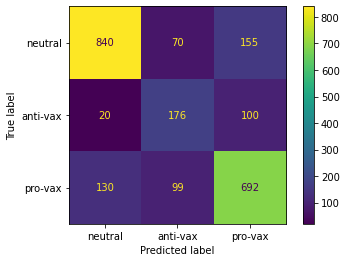

In [ ]:
target_names = ['neutral', 'anti-vax', 'pro-vax']

cm = confusion_matrix(torch.tensor(true_pred), pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()

In [ ]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(torch.tensor(true_pred), pred, average='micro'))

Precision-Recall-F1 - Training Data :
(0.7484662576687117, 0.7484662576687117, 0.7484662576687117, None)


In [ ]:
def plot_graph_loss(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , epoch_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), epoch_loss_dev, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(['train', 'validation']);

plot_graph_loss(5)

In [ ]:
def plot_graph_acc(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Accuracy")
    plt.plot(list(np.arange(epochs) + 1) , epoch_acc, label='train')
    plt.plot(list(np.arange(epochs) + 1), epoch_acc_dev, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(['train', 'validation']);

plot_graph_acc(5)    